Kenya's agriculture sector faces a pressing crisis, with millions affected by food insecurity, rampant soil degradation, and the unpredictable impacts of climate variability, such as droughts and erratic rainfall. Smallholder farmers struggle with limited access to vital data and financial resources.

To address these challenges, we propose an innovative solution: an AI-powered soil analysis and crop recommendation platform. This website will allow users to upload CSV files to analyze soil samples in real-time, delivering tailored recommendations on most appropriate crop to grow.

Additionally, in the future we hope to implement smartphone camera technology and leveraging satellite imagery through accessible APIs, such as those provided by NASA, we can enhance the accuracy of our analyses create a unique peer-to-peer marketplace where farmers in drought-prone areas, particularly in Kenya's arid regions, can trade surplus soil nutrients or connect with local suppliers. This initiative will not only reduce waste but also boost agricultural yields, helping to combat the decline in soil health and food insecurity.


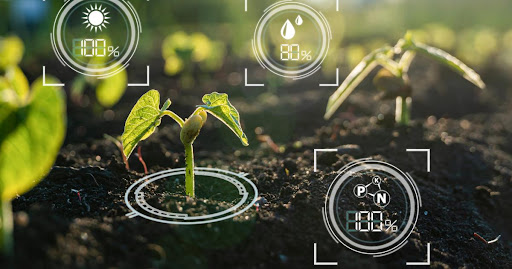

In [1]:
!pip install lightgbm catboost scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/Crop_Recomendation/Crop_recommendation.csv")

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)
data.head()

Dataset Shape: (2200, 8)
Columns: Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


Dataset Shape: (2200, 8)

Summary Statistics:
                  N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       9.93

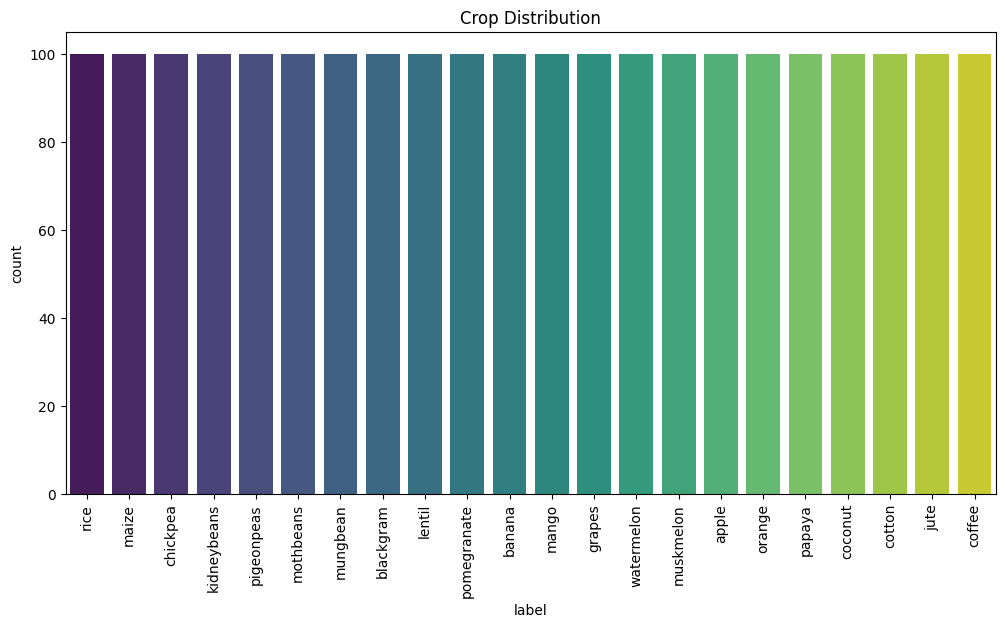

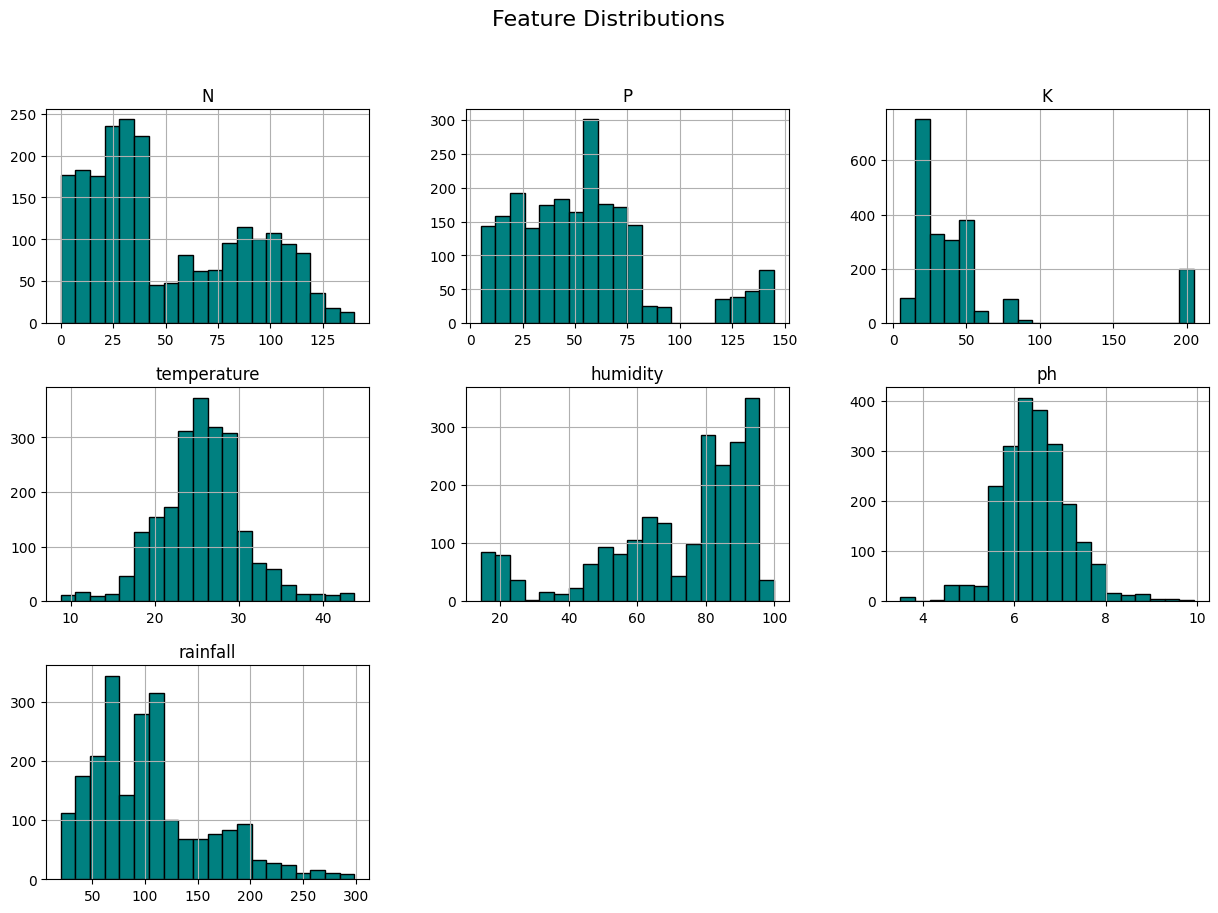

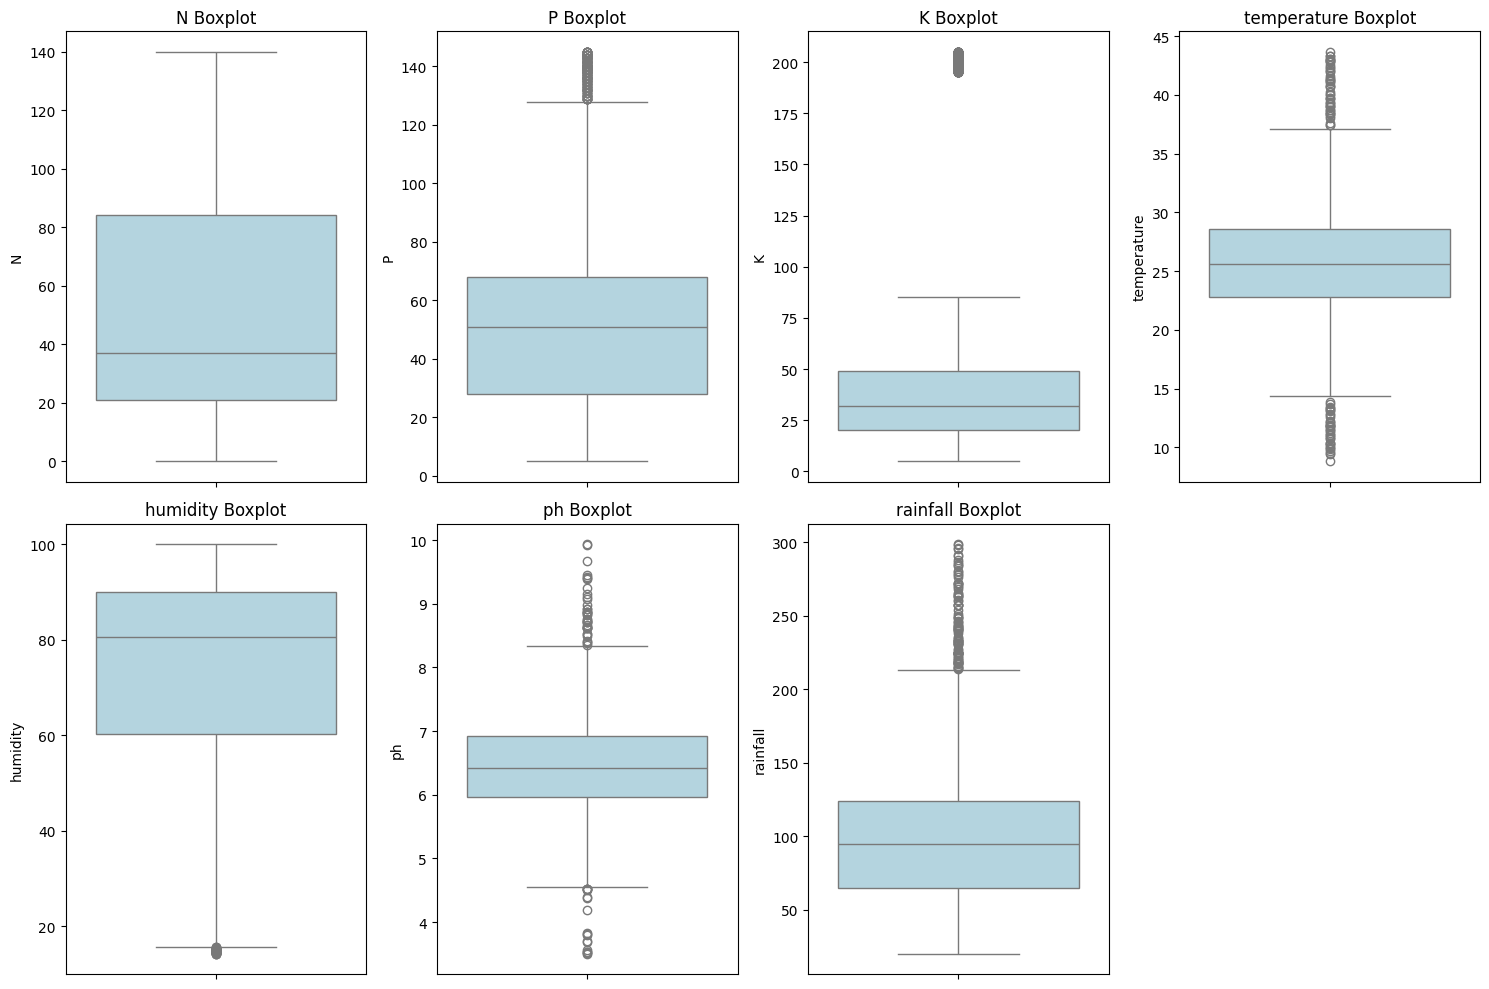

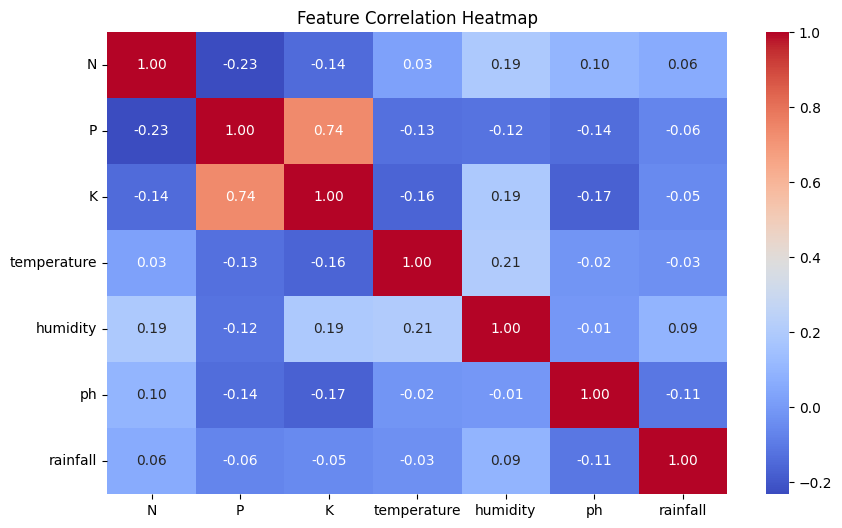

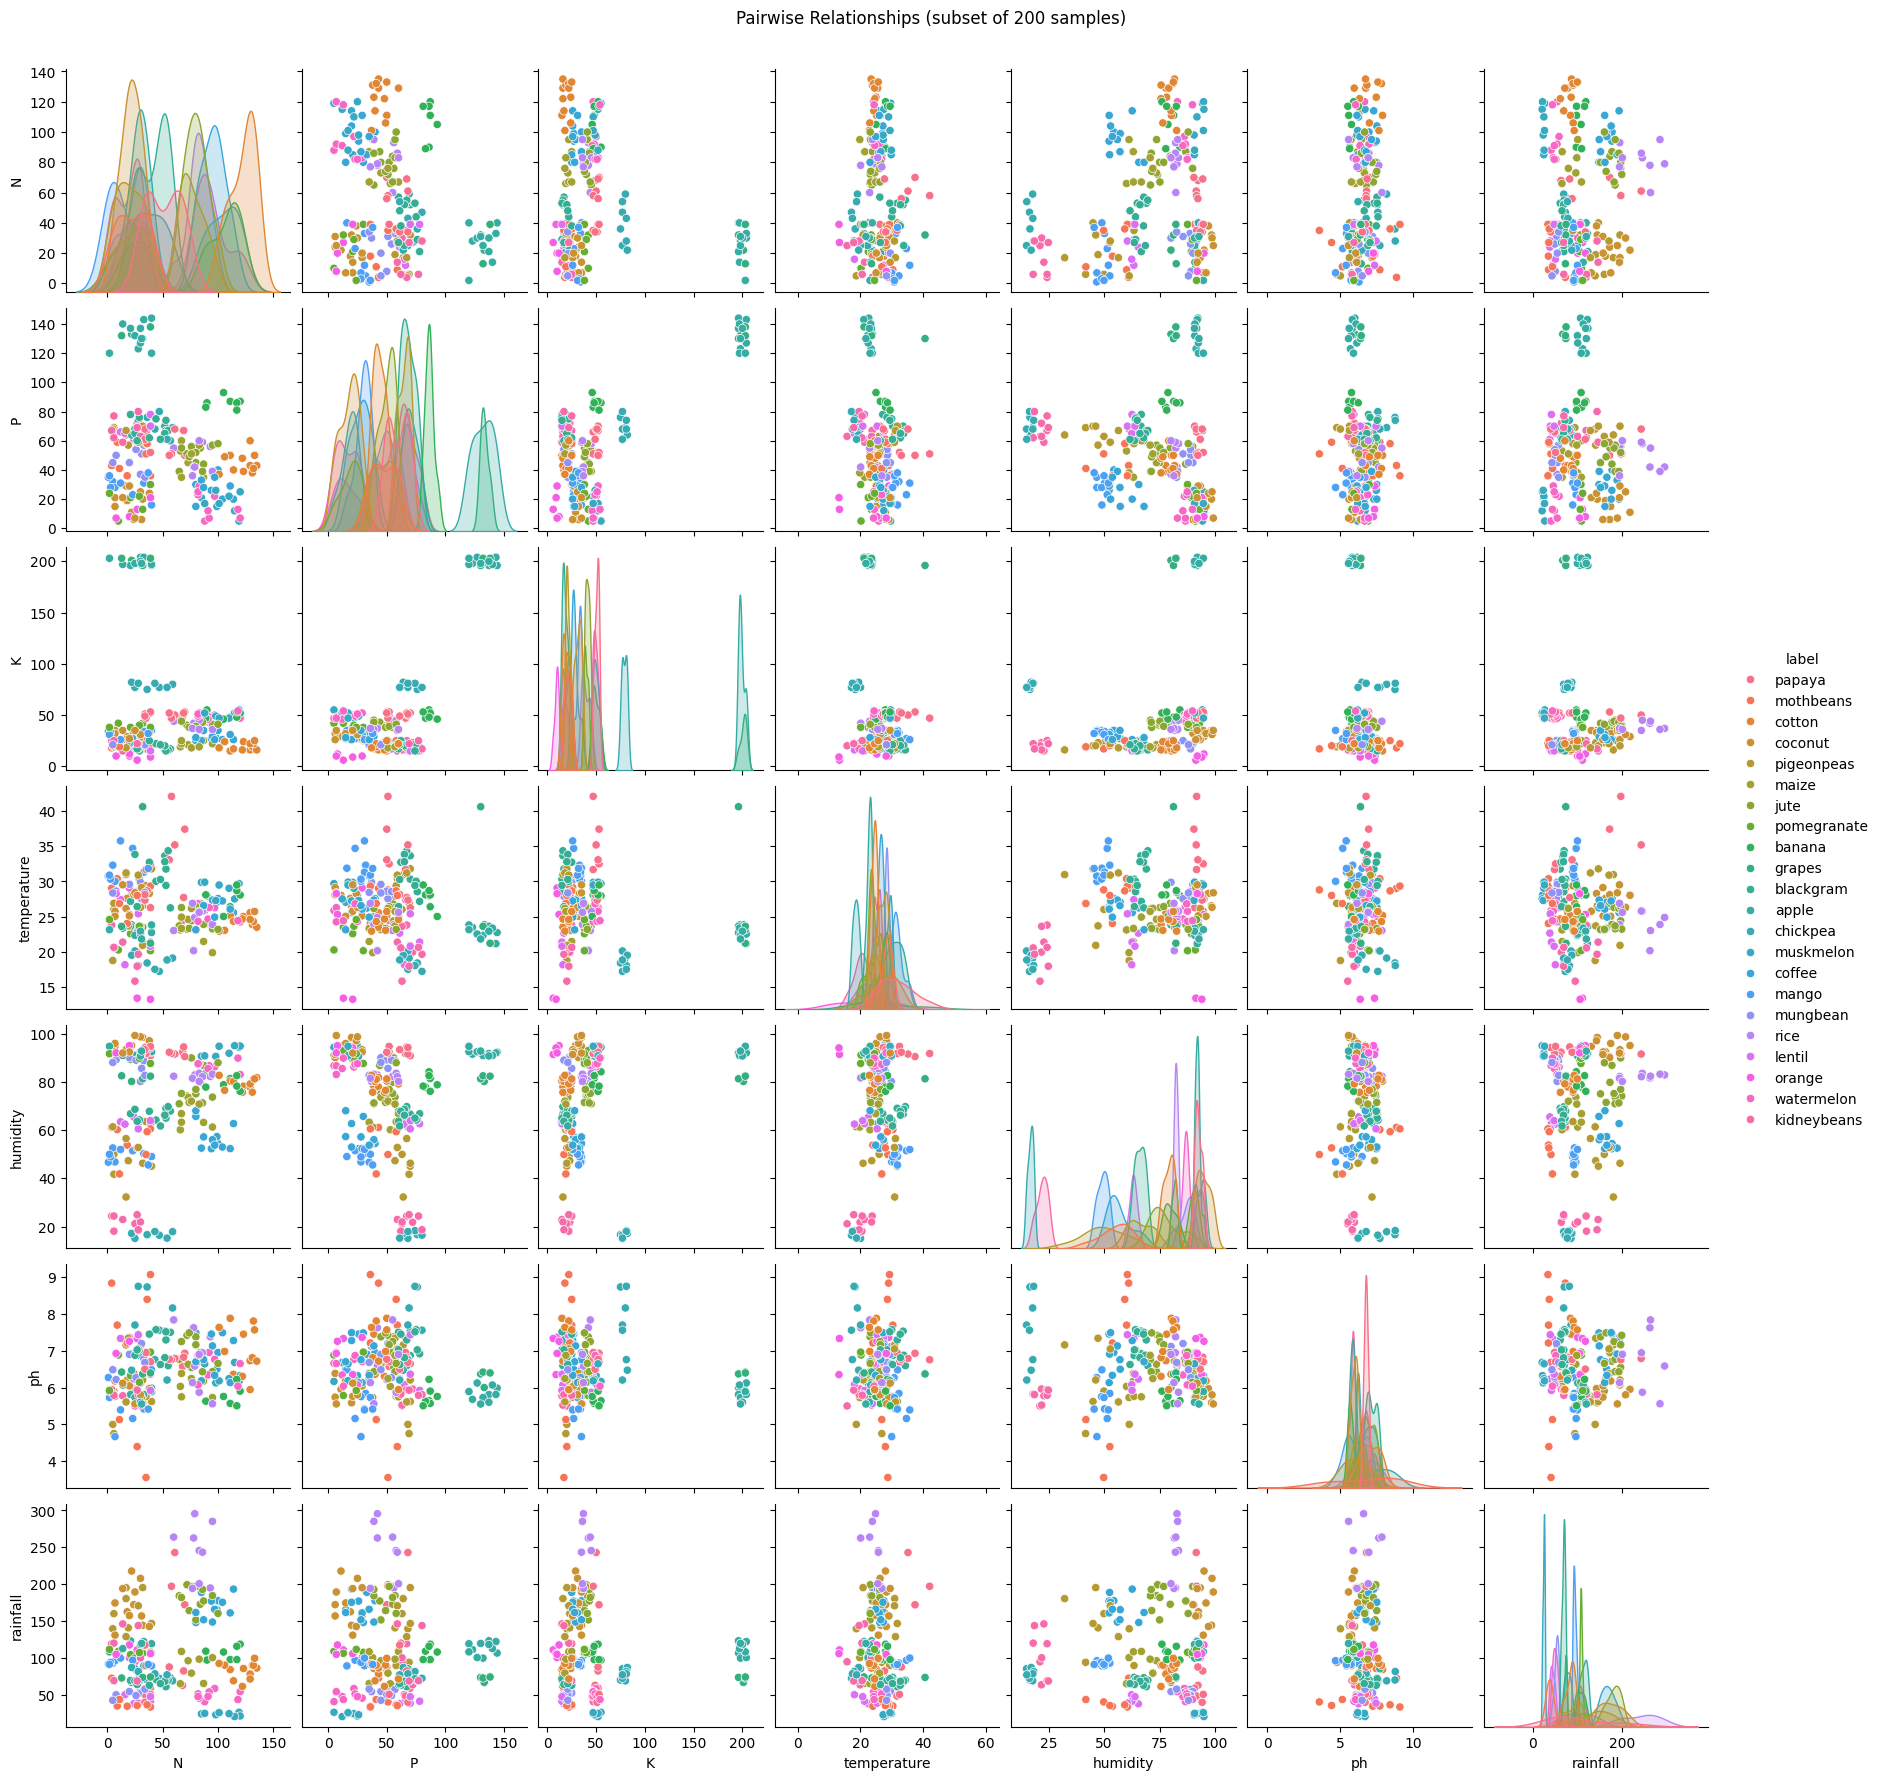

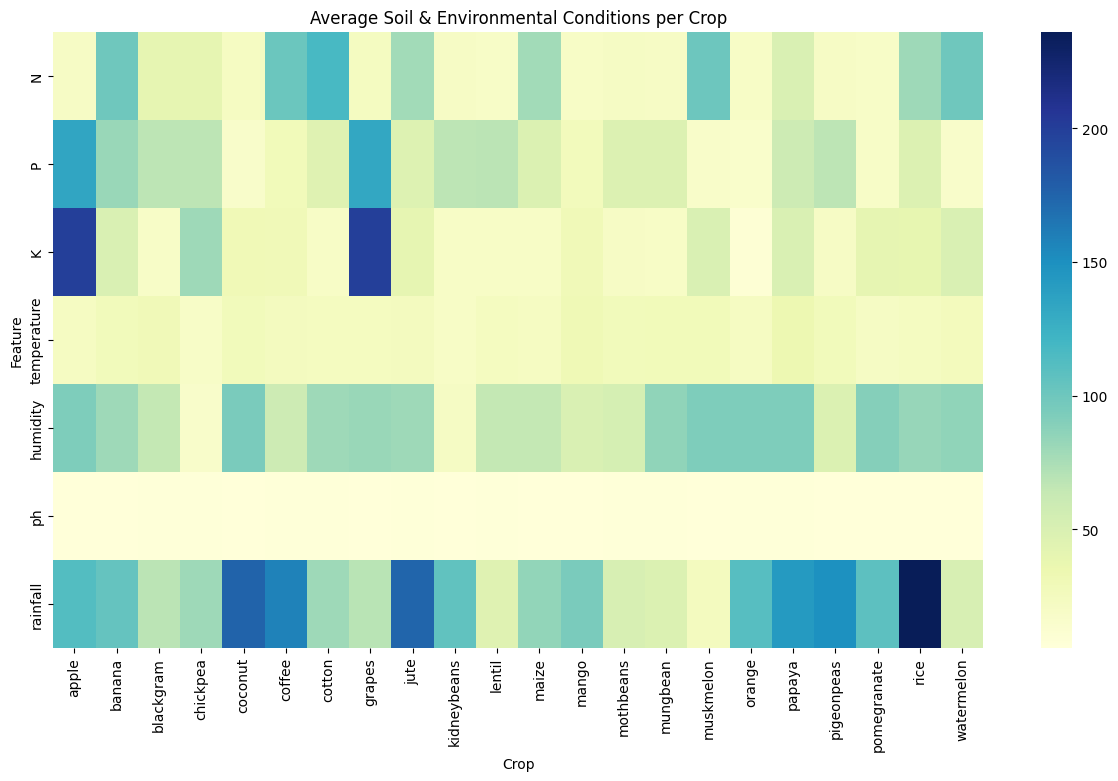

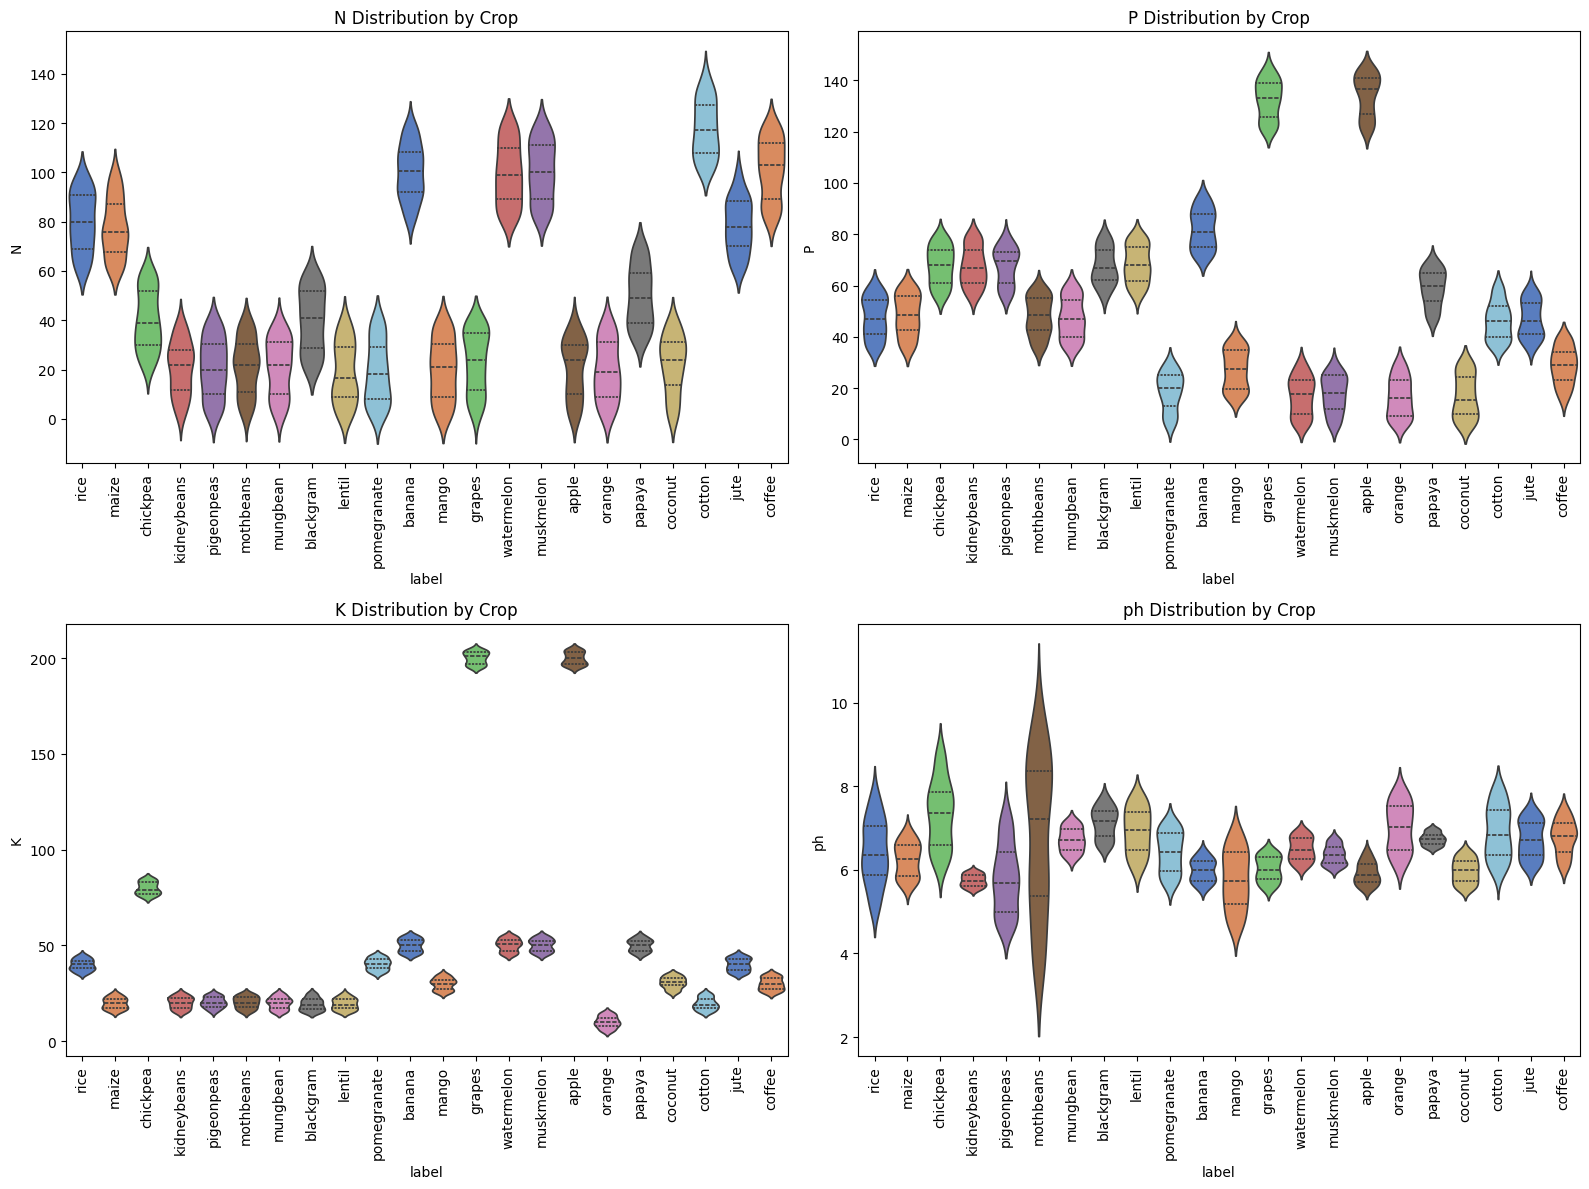

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis


print("Dataset Shape:", data.shape)
print("\nSummary Statistics:\n", data.describe())

# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())

# . Target Distribution
plt.figure(figsize=(12,6))
sns.countplot(x="label", data=data, order=data["label"].value_counts().index, palette="viridis", hue="label")
plt.xticks(rotation=90)
plt.title("Crop Distribution")
plt.show()

# . Distribution of each feature
data.hist(figsize=(15,10), bins=20, color="teal", edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# . Boxplots to check outliers per feature
plt.figure(figsize=(15,10))
for i, col in enumerate(data.drop("label", axis=1).columns, 1):
    plt.subplot(2,4,i)
    sns.boxplot(y=data[col], color="lightblue")
    plt.title(f"{col} Boxplot")
plt.tight_layout()
plt.show()

# . Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.drop("label", axis=1).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# . Pairplot (sample for first 200 rows for speed)
sns.pairplot(data.sample(200), vars=["N","P","K","temperature","humidity","ph","rainfall"], hue="label", diag_kind="kde", palette="husl")
plt.suptitle("Pairwise Relationships (subset of 200 samples)", y=1.02)
plt.show()

# . Average nutrient/environment levels per crop
avg_features = data.groupby("label").mean()

plt.figure(figsize=(15,8))
sns.heatmap(avg_features.T, cmap="YlGnBu", annot=False)
plt.title("Average Soil & Environmental Conditions per Crop")
plt.xlabel("Crop")
plt.ylabel("Feature")
plt.show()

# . Violin plots for key soil nutrients vs. crop label
plt.figure(figsize=(16,12))
for i, feature in enumerate(["N", "P", "K", "ph"], 1):
    plt.subplot(2,2,i)
    sns.violinplot(x="label", y=feature, data=data, palette="muted", density_norm='width', inner="quartile", hue="label")
    plt.xticks(rotation=90)
    plt.title(f"{feature} Distribution by Crop")
plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(data["label"])   # replace with your actual target column

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#  Features & Labels

X = data.drop("label", axis=1)
y = data["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Initialize models
rf = RandomForestClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(random_state=42, verbose=0)

# Train models
rf.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
cat.fit(X_train, y_train)

# Make predictions
rf_preds = rf.predict(X_test)
lgbm_preds = lgbm.predict(X_test)
cat_preds = cat.predict(X_test)

# Evaluate models
rf_acc = accuracy_score(y_test, rf_preds)
lgbm_acc = accuracy_score(y_test, lgbm_preds)
cat_acc = accuracy_score(y_test, cat_preds)

# Store results
results = {
    "RandomForest": rf_acc,
    "LightGBM": lgbm_acc,
    "CatBoost": cat_acc
}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 7
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Model Performance Comparison:
RandomForest: 0.9955
LightGBM: 0.9886
CatBoost: 0.9977

Best Model: CatBoost

Classification Report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
  

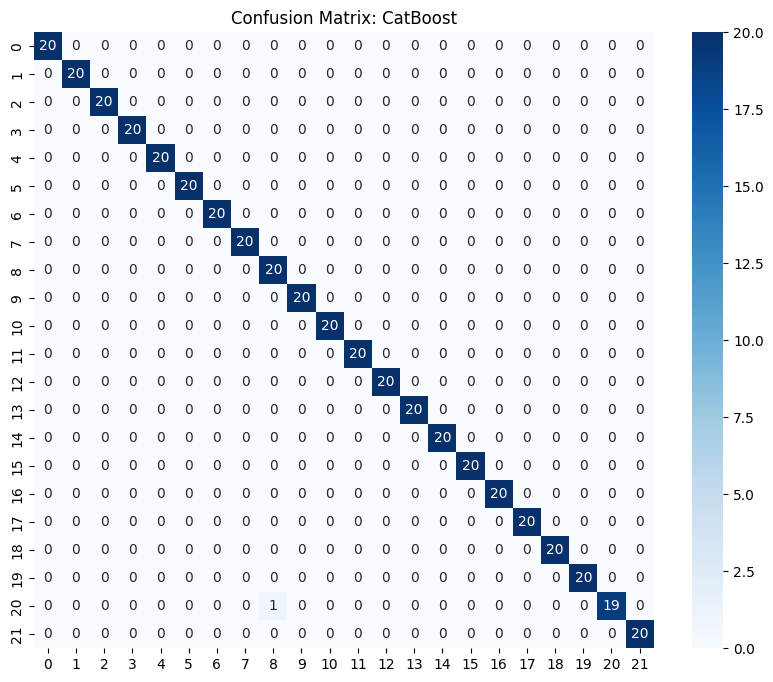

In [18]:
# STEP 7: Evaluation
print("\nModel Performance Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

best_model_name = max(results, key=results.get)
print("\nBest Model:", best_model_name)

# Classification report for best model
if best_model_name == "RandomForest":
    best_preds = rf_preds
    best_model = rf
elif best_model_name == "LightGBM":
    best_preds = lgbm_preds
    best_model = lgbm
else:
    best_preds = cat_preds
    best_model = cat

print("\nClassification Report:\n")
print(classification_report(y_test, best_preds))

# Confusion Matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, best_preds), annot=True, cmap="Blues", fmt="d")
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

/tmp/ipython-input-2701601600.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances[rf_sorted_idx], y=feature_names[rf_sorted_idx], palette="viridis")


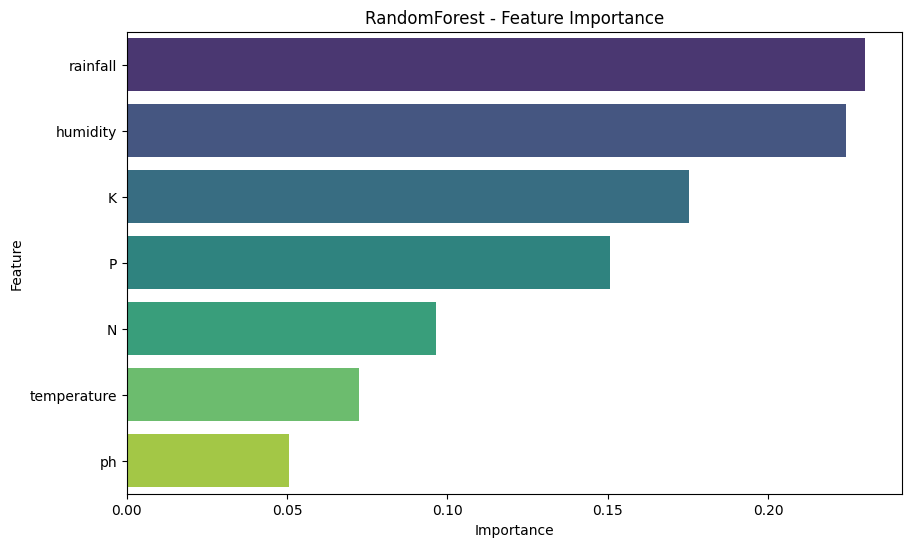

/tmp/ipython-input-2701601600.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lgb_importances[lgb_sorted_idx], y=feature_names[lgb_sorted_idx], palette="mako")


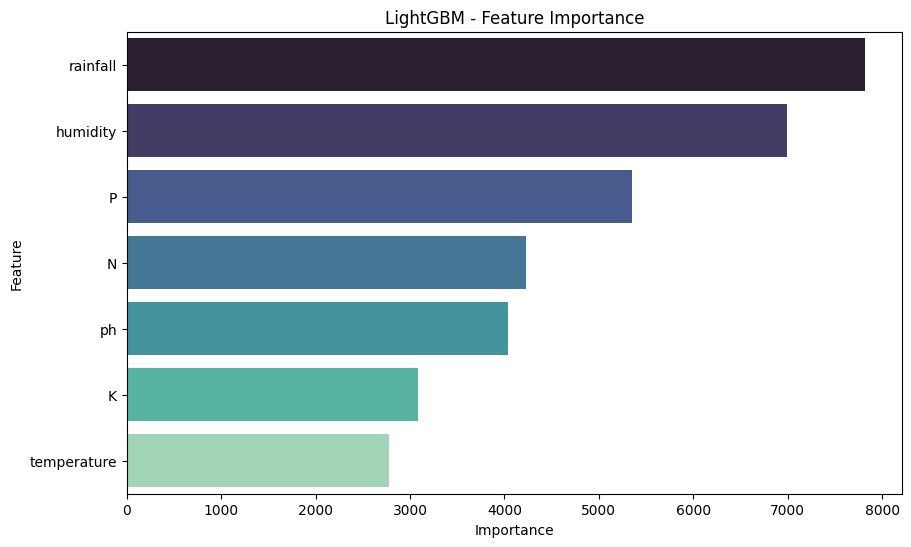

In [19]:

# Feature Importance Visualization

feature_names = X.columns

# RandomForest Feature Importance
rf_importances = rf.feature_importances_
rf_sorted_idx = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=rf_importances[rf_sorted_idx], y=feature_names[rf_sorted_idx], palette="viridis")
plt.title("RandomForest - Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# LightGBM Feature Importance
lgb_importances = lgbm.feature_importances_
lgb_sorted_idx = np.argsort(lgb_importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=lgb_importances[lgb_sorted_idx], y=feature_names[lgb_sorted_idx], palette="mako")
plt.title("LightGBM - Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [25]:
# Save model + encoder
joblib.dump(model, "/content/drive/MyDrive/Crop_Recomendation/models/crop_recommender.joblib")
joblib.dump(le, "/content/drive/MyDrive/Crop_Recomendation/models/label_encoder.joblib")

print("✅ Model and encoder saved!")

✅ Model and encoder saved!


In [26]:
# Save Best Model
joblib.dump(best_model, "/content/drive/MyDrive/Crop_Recomendation/best_crop_model.pkl")
print("Best model saved to Drive as best_crop_model.pkl")

# Also save the scaler (important for preprocessing new data later)
joblib.dump(scaler, "/content/drive/MyDrive/Crop_Recomendation/soil_scaler.pkl")

Best model saved to Drive as best_crop_model.pkl


['/content/drive/MyDrive/Crop_Recomendation/soil_scaler.pkl']

In [29]:
# 🚀 Final Model Selection & Saving for Streamlit
import joblib
import os

# Create a folder to store exported models
os.makedirs("models", exist_ok=True)

# ✅ Pick the best model based on evaluation metrics
model_scores = {
    "RandomForest": results["RandomForest"],
    "LightGBM": results["LightGBM"],
    "CatBoost": results["CatBoost"]
}

best_model_name = max(model_scores, key=model_scores.get)
print(f"🔥 Best performing model: {best_model_name} with accuracy = {model_scores[best_model_name]:.4f}")

if best_model_name == "RandomForest":
    final_model = rf
elif best_model_name == "LightGBM":
    final_model = lgbm
else:
    final_model = cat

# ✅ Save the final model in joblib format
joblib.dump(final_model, "/content/drive/MyDrive/Crop_Recomendation/models/crop_model.joblib")

# ✅ Save the label encoder (used for inverse_transform)
joblib.dump(le, "/content/drive/MyDrive/Crop_Recomendation/models/encoder.joblib")

print("✅ Model saved successfully in joblib format for Streamlit app.")

🔥 Best performing model: CatBoost with accuracy = 0.9977
✅ Model saved successfully in joblib format for Streamlit app.
